<a href="https://colab.research.google.com/github/esephaneli/EuroSAT-CNN-VGG16/blob/main/EuroSATTransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
dataset, info = tfds.load(
    "eurosat/rgb",
    split=["train[:80%]", "train[80%:]"],
    with_info=True,
    as_supervised=True
 )

In [3]:
train_ds, val_ds = dataset

In [4]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)/255.0
    label = tf.one_hot(label, 10)
    return image, label

In [5]:
train_ds = train_ds.map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [6]:
model=Sequential([
    #Konvolüsyon bloğu (EuroSAT uydu görüntüleri 64x64 piksel ve renkli)
    Conv2D(32,(3,3), activation="relu", input_shape=(64,64,3)),
    MaxPooling2D((2,2)),
    #Konvolüsyon bloğu
    Conv2D(64,(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    #Bu blok daha karmaşık özellikleri yakalayabilsin diye 128 katman seçtim.
    Conv2D(128,(3,3), activation="relu"),
    MaxPooling2D((2,2)),
    #Resimden aldığımız özellikleri tek sıraya indirgemek.
    Flatten(),
    #Yapay sinir ağımız
    Dense(128, activation="relu"),
    Dropout(0.5),
    #10 farklı sınıf olduğu için 10 nöron ve softmax seçtim
    Dense(10,activation="softmax")


])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy", #Çoklu sınıflandırma "crossentropy"
    metrics=["accuracy"]
)

In [ ]:
model.summary()

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
early_stopping=EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True,verbose=1)

In [11]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stopping])

Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.3070 - loss: 1.7806 - val_accuracy: 0.6043 - val_loss: 1.0880
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5643 - loss: 1.1454 - val_accuracy: 0.7313 - val_loss: 0.7331
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6781 - loss: 0.9070 - val_accuracy: 0.7715 - val_loss: 0.6285
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7280 - loss: 0.7791 - val_accuracy: 0.7478 - val_loss: 0.6669
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7527 - loss: 0.7087 - val_accuracy: 0.7265 - val_loss: 0.7787
Epoch 6/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7689 - loss: 0.6657 - val_accuracy: 0.8096 - val_loss: 0.5385
Epoch 7/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7962 - loss: 0.5930 - val_accuracy: 0.7781 - val_loss: 0.6348
Epoch 8/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8107 - loss: 0.5506 - val_accuracy: 

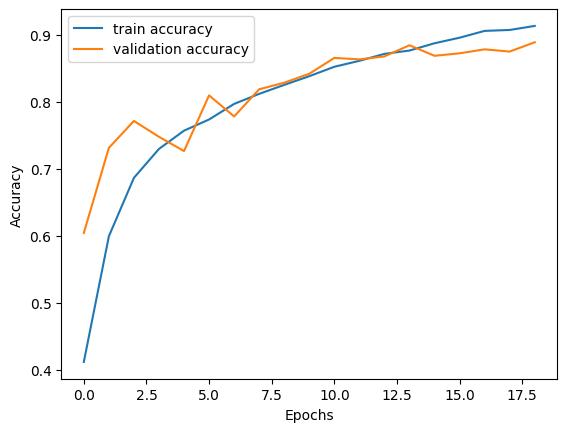

In [12]:
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

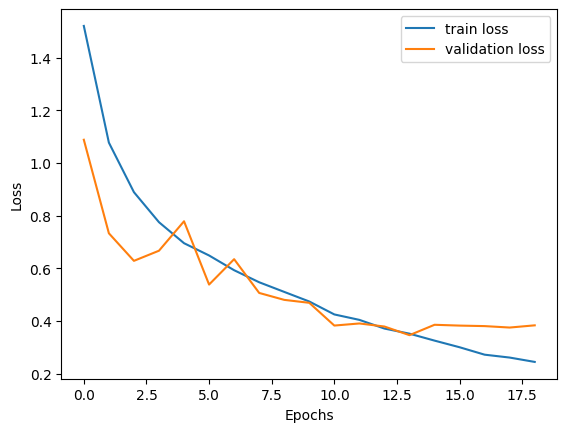

In [13]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

In [15]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(64,64,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
conv_base.trainable = False

In [17]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

In [ ]:
model.summary()

In [19]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [20]:
early_stopping=EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True,verbose=1)

In [21]:
historyVGG = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stopping])

Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.6283 - loss: 1.0511 - val_accuracy: 0.8133 - val_loss: 0.5259
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.7976 - loss: 0.5825 - val_accuracy: 0.8441 - val_loss: 0.4627
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.8221 - loss: 0.5132 - val_accuracy: 0.8550 - val_loss: 0.4125
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.8370 - loss: 0.4817 - val_accuracy: 0.8550 - val_loss: 0.4108
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.8465 - loss: 0.4385 - val_accuracy: 0.8693 - val_loss: 0.3786
Epoch 6/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.8525 - loss: 0.4274 - val_accuracy: 0.8609 - val_loss: 0.3910
Epoch 7/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.8611 - loss: 0.4124 - val_accuracy: 0.8715 - val_loss: 0.3707
Epoch 8/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.8667 - loss: 0.3892 - 

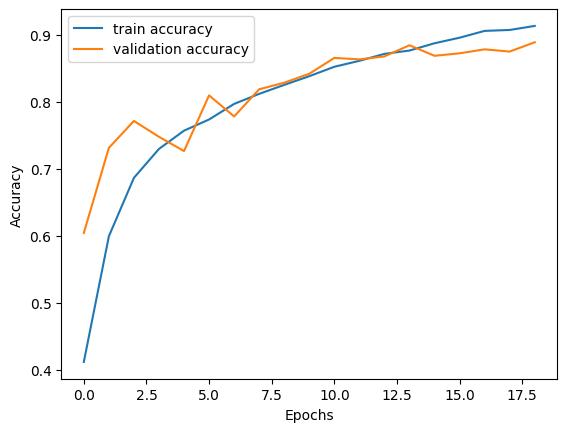

In [22]:
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

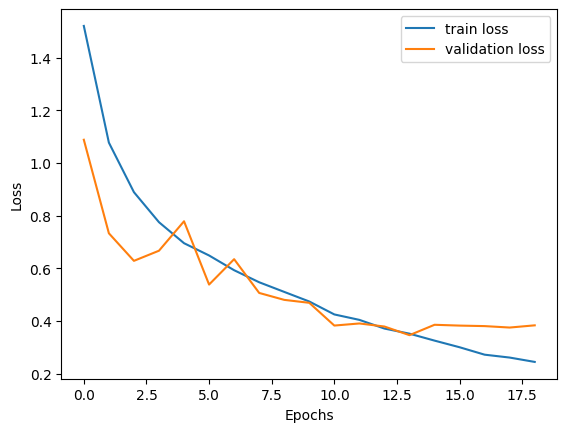

In [23]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()